# $Clase \ 27-Octubre-2020$

# Redes aleatorias (Erdős-Rényi)
En este notebook se introduce la noción de red aleatoria de Erdős-Rényi. Posteriormente se introducen dos métodos para generarlas como objetos de networkx y comenzar a analizar sus propiedades. Particularmente nos concentraremos en:
- número de enlaces
- valor esperado del grado
- coeficiente de acumulación esperado
- distribución de grado

## Definiciones
Una red aleatoria es aquella en la que la asignación de los enlaces se hace a partir de un mecanismo aleatorio. Hay dos tipos de definiciones posibles:
- Modelo $G(N,L)$ en el que se fijan el número de nodos $N$ y el número de enlaces $L$. Los enlaces se asignan de forma aleatoria entre los nodos, esto es, se seleccionan aleatoriamente $L$ parejas de nodos, de entre las $\frac{N(N-1)}{2}$ parejas posibles.
- Modelo $G(N,p)$ en el que la probabilidad de que entre dos nodos haya un enlace es igual a $p\le1$.
En este notebook se usa esta última definición.

A continuación se proporcionan dos funciones. Una es para generar los enlaces aleatorios (las parejas) entre los $N$ nodos, dada la probabilidad $p$. La otra es para generar la red a partir de los nodos y los enlaces previamente generados.

## Definición según probabilidad de enlace
La siguiente funcion ```enalces_aleatorios``` recibe como parámetros el número de nodos $N$ y la probabilidad de enlace entre pares $p$. Lo que hace es recorrer, mediante dos bucles anidados (uno dentro de otro) todas las parejas de nodos. Para cada pareja de nodos, genera un número aleatorio entre 0 y 1 mediante la función de numpy ```np.random.rand()``` y si este es menor que $p$, registra el enlace.

Deben poner atención a que en esta ocasión no se utiliza la instrucción ```return``` al final de la definición. En su lugar se utiliza la instrucción ```yield```, que es un generador que permite dar múltiples salidas a la función. Además tiene la ventaja de que la información que se genera no ocupa espacio en la memoria, aunque tiene la desventaja de que después de utilizar la información una vez, ya no se puede volver a utilizar. Para más información pueden googlearlo, aquí un ejemplo: https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/

En resumen, la función ```enlaces_aleatorios(N,p)``` es un generador de parejas de nodos, es decir de enlaces. Estas parejas serán utilizadas en la función ```red_aleatoria``` para generar una red de $N$ nodos enlazados según la probabilidad $p$. Lo único que hace esta última es generar el objeto ```nx.Graph()```, agregar los nodos y agregar los enlaces.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def enlaces_aleatorios(N, p):
  for i in range(N):
    for j in range(i):
      if np.random.rand() < p:
        yield i,j

def red_aleatoria(N, p):
  G = nx.Graph()
  G.add_nodes_from(range(N)) # agrega todos los nodos
  
  G.add_edges_from( enlaces_aleatorios(N, p) ) # agrega los enlaces obedeciendo la probabilidad p
  
  return G

En la siguiente celda pueden jugar con el número de nodos y la probabilidad, para empezar a explorar visualmente las características cualitativas de la red: ¿está formada por una o más componentes?, ¿hay nodos aislados?

Pueden jugar con las funciones ```nx.draw()``` o sus derivadas ```nx.draw_circular()```, la kamada_kawai, etc.

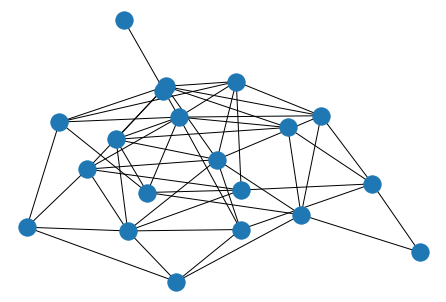

In [32]:
N = 20
p = 0.2

nx.draw_kamada_kawai(red_aleatoria(N,p))

## Definición con matriz de adyacencia aleatoria
A continuación se les propone otra implementación, esta vez basada en la matriz de adyacencia. Básicamente se genera una matriz con las propiedades de una matriz de adyacencia (formada por ceros y unos, diagonal igual a cero, simétrica) en la que la entrada correspondiente a cada enlace tiene valor 1 con probabilidad $p$, y 0 con probabilidad $p-1$. Después se utiliza la función ```nx.from_numpy_array()``` para convertir esa matriz de adyacencia en su representación como red.

Para la implementación se utilizan las siguientes funciones:
- ```np.ones((N,N))```: genera un arreglo de numpy de dimensión $N\times N$ de puros 1's.
- ```np.triu()```: a partir de un arreglo de numpy, genera su matriz triangular superior (upper triangular). El parámetro ```k``` que recibe indica a partir de cuál diagonal generar la matriz triangular. ```k = 0``` respeta la diagonal principal, aquí necesitamos que la diagonal principal sea de ceros, por lo que utilizamos ```k = 1```
- ```np.random.rand(N,N)```: genera un arreglo de numpy de dimensión $N\times N$ de números aleatorios entre 0 y 1.
- Nota: observen cómo se puede aplicar el comparador $<$ al arreglo de numpy, lo cual tendrá como resultado una matriz de valores booleanos (True / False) que después puede multiplicarse por la matriz triangular superior. La multiplicación que se realiza es ```A*B```, no es una multiplicación matricial sino una multiplicación elemento a elemento. En este caso, el valor True toma el valor 1 y False el valor 0.

Ya que se generó la matriz triangular superior, se genera la matriz de adyacencia sumando la triangular y su transpuesta, que sería una triangular inferior.

En la siguiente celda pueden variar los valores de $N$ y $p$ y visualizar el resultado

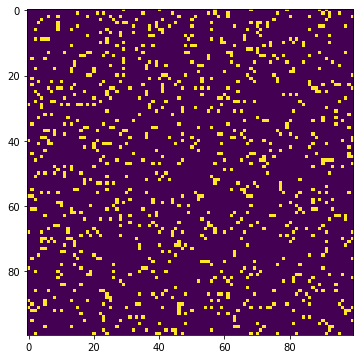

In [98]:
N = 100
p = .1

A = np.triu(np.ones((N,N)), k = 1)*(np.random.rand(N,N) < p)
A = A.T + A

plt.figure(figsize = [6,6])
plt.imshow(A)

## Ejercicio 1
Utilicen el código anterior para generar la matriz de adyacencia para generar una función que tome los parámetros  N  y  p  y regrese (return) la red aleatoria correspondiente

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def red_aleatoria(N,p):
   
    A = np.triu(np.ones((N,N)), k = 1)*(np.random.rand(N,N) < p)
    A = A.T + A
                      
    G = nx.from_numpy_array(A)
    
    plt.figure(figsize = [6,6])
    nx.draw(G, with_labels = True, node_color = "pink")
                    
    return G

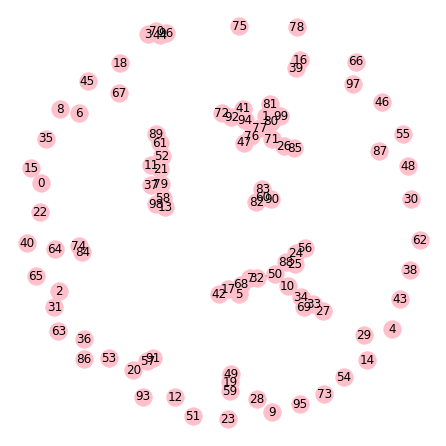

In [27]:
red_aleatoria(100,0.01)

## Número esperado de enlaces
A partir de cualquiera de las dos definiciones utilizadas hasta ahora, se pueden estudiar las propiedades de la red aleatoria. Empezaremos con el estudio de el número de enlaces.

Algo a tomar en cuenta es que al tratarse de una red de carácter aleatorio, cada vez que generemos una debemos considerarla una realización. Cada realización tendrá propiedades distintas: distinto número de enlaces, distinta distribución de grado, distinto grado promedio, coeficiente de acumulación, etc. Para estudiar las propiedades de la red aleatoria en abstracto, debemos considerar cada realización como parte de un conjunto (o un ensemble) de redes aleatorias de las que estudiaremos sus propiedades estadísticas. 

Particularmente, el número esperado de enlaces se estudiará generando muchas redes aleatorias, contando el número de enlaces de cada una y promediando sobre todas las redes (realizaciones).

Recordar que cada red tiene la propiedad ```.edges``` que es la lista de todos sus enlaces. Con esa propiedad y la funcion ```len()``` sabremos cuántos enlaces tiene cada red. En la siguiente celda puedes jugar con el número de nodos y la probabilidad $p$ para contar el número de enlaces. Corre varias veces la celda con los mismos parámetros para verificar que cada realización tiene distinto número de enlaces:

42

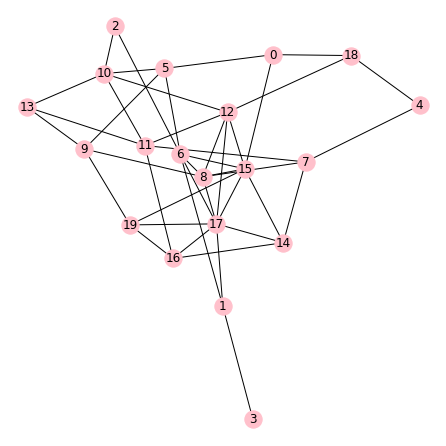

In [117]:
N = 20
p = .2
G = red_aleatoria(N,p)

len(G.edges)

### Ejercicio 2
Mediante un ```for``` genera muchas realizaciones (corridas) y guarda el número de enlaces $L$ de cada una en una lista. Mediante la función de numpy ```np.mean()``` puedes obtener el promedio sobre todas las corridas, es decir, el valor esperado del número de enlaces.

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def enlaces_promedio(N,p, corridas):
   
    A = np.triu(np.ones((N,N)), k = 1)*(np.random.rand(N,N) < p)
    A = A.T + A
                      
    G = nx.from_numpy_array(A)
   
    lista_L = [] 
    for i in range(corridas):
        L = len(G.edges)

        lista_L.append(L)
        
    return 'El valor promedio de enlaces es '+ str(np.mean(lista_L) ) 

In [94]:
enlaces_promedio(100,0.1,100)

'El valor promedio de enlaces es 531.0'

### ¿Puedes encontrar una expresión del valor esperado de $L$ que relacione a $N$ y $p$? (Redondea el valor esperado para muchas corridas, digamos 1000)

En primer lugar estamos trabajando con una distribución binomial por lo que su distribución de probabilidad está dada por

$$ f_N(L) = \begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^L(1-p)^{\frac{N(N-1)}{2}-L}$$

ya que podemos tener un total de $\frac{N(N-1)}{2}$ enlaces en la red. Lo que nos dice $f_N(L)$ es la probabilidad de obtener un total de $L$ enlaces de los $\frac{N(N-1)}{2}$ enlaces posibles sin distinguir entre los nodos. De esta manera el valor esperado $\langle L \rangle$ viene dado por

$$
    \langle L \rangle = \sum_{L = 0}^{\frac{N(N-1)}{2}} Lf_N(L) = \sum_{L = 0}^{\frac{N(N-1)}{2}} L\begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^L(1-p)^{\frac{N(N-1)}{2}-L}
$$

sustituimos $q = 1 - p$ de tal manera que

$$
    \langle L \rangle = \sum_{L = 0}^{\frac{N(N-1)}{2}} L\begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^Lq^{\frac{N(N-1)}{2}-L} = p\sum_{L = 0}^{\frac{N(N-1)}{2}} L\begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^{L-1}q^{\frac{N(N-1)}{2}-L}
$$

siendo que

$$
    \frac{\partial}{\partial p}\left(\begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^{L}q^{\frac{N(N-1)}{2}-L}\right) = L\begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^{L-1}q^{\frac{N(N-1)}{2}-L}
$$

entonces

$$
    \langle L \rangle = p\sum_{L = 0}^{\frac{N(N-1)}{2}}\frac{\partial}{\partial p}\left(\begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^{L}q^{\frac{N(N-1)}{2}-L}\right)
$$

y por la linealidad de la derivada

$$
    \langle L \rangle = p\frac{\partial}{\partial p}\sum_{L = 0}^{\frac{N(N-1)}{2}}\begin{pmatrix} \frac{N(N-1)}{2} \\ L \end{pmatrix}p^{L}q^{\frac{N(N-1)}{2}-L} = p\frac{\partial}{\partial p}(p+q)^{N(N-1)/2} = p\frac{N(N-1)}{2}(p+q)^{\frac{N(N-1)}{2}-1}
$$

siendo que $q = 1 - p$ entonces $p + q = 1$ entonces el valor esperado para el número de enlaces viene dado por

<font color = red>
    
$$
    \langle L \rangle = p\frac{N(N-1)}{2}
$$

#### Distribución de probabilidad de L
Ahora se generará un histograma de frecuencias de los valores de $L$ para ver cómo se comportan.
Para ello utilizaremos la función ```np.histogram()``` que recibe una lista o arreglo y regresa el histograma. Los parámetros que utilizamos son:
- ```bins = range(N*(N-1)/2)```: los bins son las "cajitas" dentro de las cuales se agrupará y contará a los valores. Al dar esta instrucción estamos diciendo que tome cajas uniformes, con los valores desde 0 hasta N(N-1)/2 (el máximo valor posible para L, tal y como vimos la primera semana)

Lo que regresa la función ```histogram``` es primero las cuentas de los valores para cada intervalo y luego los extremos de los intervalos en sí. Por ello debemos guardar ambas cantidades como $y$ y $x$, respectivamente.

In [110]:
# elige los valores para N, p y el numero de corridas
N = 20
p = 0.2
corridas = 100

lista_L = []  # esta linea define una lista sin elementos a la que se iran agregando los valores de L
for i in range(corridas):
    
    #En la siguiente linea genera una red aleatoria con los parametros indicados
    G = red_aleatoria(N,p)
    
    #Ahora calcula el numero de enlaces de la red generada
    L = len(G.edges)
    
    lista_L.append(L) #aqui se agrega el valor de L a la lista


print('El valor esperado de L es ', np.mean(lista_L))

El valor esperado de L es  38.94


In [111]:
y, x = np.histogram(lista_L, bins = range(int(N*(N-1)/2)))

A continuación se puede visualizar el histograma. Como el arreglo $x$ representa los valores extremos de los intervalos, tiene un valor extra, por eso debemos excluirlo al momento de graficar (por eso se indica ```x[:-1]```, que equivale a todos los elementos menos el último)

Como podrás ver, los valores de $L$ están muy concentrados. Mediante la asignación de valores ```xmin``` y ```xmax``` puedes utilizar la instrucción ```plt.xlim()``` para acotar tu gráfica en el dominio donde veas que se concentran los valores. Así puedes analizar la estructura de la distribución con más detalle.
**Debes descomentar esas líneas y asignar los valores xmin y xmax**

(0.0, 75.0)

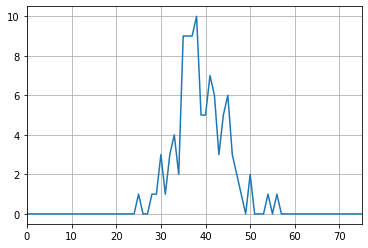

In [112]:
plt.plot(x[:-1], y)
plt.grid()

xmin = 0
xmax = 75
plt.xlim([xmin, xmax])

## Grado promedio esperado
### Ejercicio 3


Ya que tienes el valor esperado del número de enlaces se puede calcular el valor esperado del grado promedio, mediante la expresión que obtuvimos la primera semana:
$$\left<k\right> = \frac{2L}{N}$$

Con esto, ¿podrías encontrar una expresión para $\left<k\right>$ que relacione a $N$ y $p$? 

Usando la expresión anterior para $\langle L \rangle$ tendriamos

<font color = red>

$$
    \langle k \rangle = p(N-1)
$$

## Coeficiente de acumulación promedio
### Ejercicio 4
Genera redes aleatorias para distintos valores de $N$ y $p$. Para cada una calcula su coeficiente de acumulación promedio (varias veces para cada uno, a ver si encuentras una regularidad).

¿Podrías encontrar una expresión para $\left<C\right>$ (coeficiente de acumulación promedio) en términos de $N$ o $p$?

En la parte de abajo para un valor considerablemente alto de N realizamos diferentes gráficos comparando el coeficiente de acumulación promedio en función a $p \in (0,1)$.
Vemos que el resultado se aproxima mucho a la recta $\langle C \rangle(p) = p$ por lo que intuimos que

<font color = red>
$$
    \langle C \rangle = p
$$

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def clustering1(N,p, corridas):
   
    A = np.triu(np.ones((N,N)), k = 1)*(np.random.rand(N,N) < p)
    A = A.T + A
                      
    G = nx.from_numpy_array(A)
    
    Clustering_promedio = nx.average_clustering(G)
        
    return "El clustering promedio es "+ str(Clustering_promedio)

In [55]:
clustering1(250,0.654191, 1)

'El clustering promedio es 0.6525579236297375'

In [48]:
import numpy as np
from numpy.random import random as rng
import networkx as nx


def clustering2(N, corridas):

    repeticiones = [i for i in range(0,corridas)]
    probabilidad = [ ]

    for i in range(0,corridas):
        probabilidad.append( rng() )

    for i in repeticiones:
        p = probabilidad[i]

        A = np.triu(np.ones((N,N)), k = 1)*(np.random.rand(N,N) < p)
        A = A.T + A
                      
        G = nx.from_numpy_array(A)
        
        print('El coeficiente de acumulación promedio para la red con'+' p='+ 
              str(probabilidad[i])+' es:\n', nx.average_clustering(G))

In [50]:
clustering2(250,1)

El coeficiente de acumulación promedio para la red con p=0.6541918817885447 es:
 0.6593669551238637


## Distribución de grado
Finalmente, realizaremos un análisis de la distribución de grado de las redes. Para ello, mediante un bucle ```for``` generaremos redes aleatorias y obtendremos, para cada una, el histograma de grados. Cada histograma lo agregaremos a un histograma acumulado (sobre todas las corridas) con el que podremos obtener el promedio de la distribución de grado para todas las corridas. Algunas consideraciones:
- Vamos a generar histogramas como ya se hizo antes, pero ahora los grados sólo pueden ir de 0 a $N-1$, por lo que le damos un ```bins = range(N)```
- Antes del ```for```, generamos un arreglo de puros ceros, con longitud $N-1$. Ahí se van a sumar los histogramas de cada realización para luego dividirlo entre el número de corridas y nos dará la distribución promedio sobre todas las corridas.
- El histograma lo hacemos bajo la misma lógica que cuando hicimos la distribución de grado en la sesión práctica 4 (https://www.youtube.com/watch?v=FFq40_AXhSM) pero ahora utilizando la función ```histogram```.


### Ejercicio 5
Juega con distintos valores de $N$, $p$ y el número de corridas para observar cómo se modifica el histograma. ¿Podrías encontrar una relación entre $N$, $p$ y el comportamiento cualitativo del histograma? (su centro, su anchura, su altura, etc.)


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def red_aleatoria(N,p):
   
    A = np.triu(np.ones((N,N)), k = 1)*(np.random.rand(N,N) < p)
    A = A.T + A
                      
    G = nx.from_numpy_array(A)
    
    #plt.figure(figsize = [6,6])
    #nx.draw(G, with_labels = True, node_color = "pink")
                    
    return G

<BarContainer object of 99 artists>

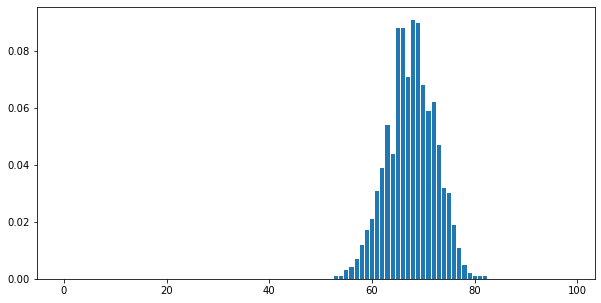

In [62]:
from numpy.random import random as rng

Nodos= 20
corridas = 10

repeticiones = [i for i in range(0,corridas)]
probabilidad = []

for i in range(0,corridas):
    probabilidad.append(rng())

for i in repeticiones:
    p = probabilidad[i]
    
Y = np.zeros(N-1)

for i in range(corridas):
    G = red_aleatoria(N,p)
    y, x = np.histogram([dict(G.degree)[i] for i in G], bins = range(N), density=True)
    Y += y
Y = Y/corridas

plt.figure(figsize = [10,5])
plt.bar(x[:-1],Y)

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def histograma(N,p,corridas):
   
    A = np.triu(np.ones((N,N)), k = 1)*(np.random.rand(N,N) < p)
    A = A.T + A
                      
    G = nx.from_numpy_array(A)
    
    Y = np.zeros(N-1)
    for i in range(corridas):
        y, x = np.histogram([dict(G.degree)[i] for i in G], bins = range(N))
        Y += y
       
    Y = Y/corridas
                
    plt.figure(figsize = [10,5])
    fig = plt.bar(x[:-1],Y)
    
    return fig

<BarContainer object of 99 artists>

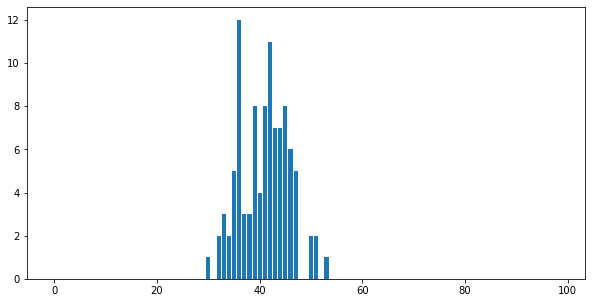

In [84]:
histograma(100,0.4,10)

<BarContainer object of 999 artists>

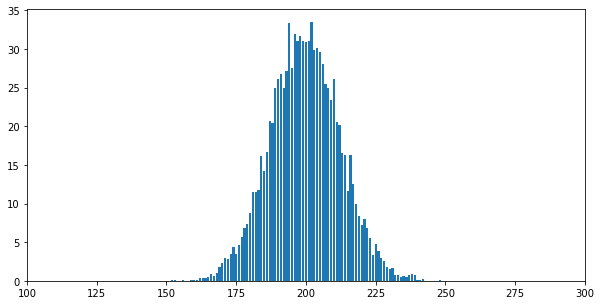

In [47]:
N = 1000
p =0.2
corridas = 10

Y = np.zeros(N-1)

for i in range(corridas):
    G = red_aleatoria(N,p)
    y, x = np.histogram([dict(G.degree)[i] for i in G], bins = range(N))
    Y += y
Y = Y/corridas

plt.figure(figsize = [10,5])
plt.xlim(100,300)
plt.bar(x[:-1],Y)